## This notebook shows how to run the comparisons performed, for the different datasets available.

The analysis were performed with [VETA](https://github.com/PedroBarbosa/VETA), a simple standalone tool designed to benchmark prediction tools from VCF files. VETA's single requirement is that it just accepts VCFs annotated with [Ensembl VEP](https://www.ensembl.org/info/docs/tools/vep/script/index.html), because the `CSQ` INFO field is used to extract additional information about the variants being evaluated. 

Predictions from the different methods can be added using [VEP plugins](http://www.ensembl.org/info/docs/tools/vep/script/vep_plugins.html) that are added in the `CSQ`, or one can use any other annotator ([bcftools annotate](https://samtools.github.io/bcftools/bcftools.html), [vcfanno](https://github.com/brentp/vcfanno), etc) as long as the prediction values are stored as independent INFO fields. For this paper, we used a combination of VEP and vcfanno.

Conda and git are required to setup the environment to run everything

In [ ]:
# ! git clone https://github.com/PedroBarbosa/VETA.git
# ! cd VETA && git checkout 1e98dee5991a08f1ba87f62c318c9a7fd619595c
# ! conda env create -f https://raw.githubusercontent.com/PedroBarbosa/paper_HCM_benchmark/main/conda_environment.yml
# ! conda activate hcm_benchmark
# ! cd VETA && pip install .

Alternatively, one can install VETA from pypi

In [1]:
#! pip install veta==0.6.0

# To open pdf images within the notebook
#! pip install Wand 


In [12]:
from wand.image import Image as WImage

# 1st analysis - Reference thresholds are not adjusted for HCM variant priorization

To test this hypothesis, we will run the benchmarks on each dataset separately and compare the tools performance between fixed thresholds and ROC curves (multiple thresholds).

We then inspect how much the performance of each tool on each dataset is affected by the use of a reference threshold that may no be well suited to HCM.

### 1st dataset - Clinvar HCM dataset evaluation

***Filtering the whole Clinvar database***

To select the HCM-associated variant, we filtered the Clinvar dataset within VETA, since the this tool has specific utilities to deal with Clinvar.\
We use a combination of the HCM identifiers across 3 different disease ontologies (`MedGen`, `OMIM`, `MONDO`) to select the variants to evaluate.\
Additionally, we set the `--clinvar_stars` argument to `1s_l` to only use variants with some confidence degree (> 1 star with likely assignments).

At the end, this VETA run was just performed to extract clinvar variant IDs associated with HCM.

In [4]:
# ! veta benchmark --out_dir id_extraction \
#                 --medgen_ids C3495498 C0949658 \
#                 --omim_ids 192600 \
#                 --mondo_ids 0005045 0024573 \
#                 --clinvar_stars 1s_l \
#                 clinvar_full.vcf.gz 

Create a new VCF with the filtered variants

In [5]:
# ! bcftools view -h clinvar_full.vcf.gz > header
# ! bcftools view -H clinvar_full.vcf.gz > body
# ! awk 'NR==FNR{a[$0]=1;next}a[$3]' ../id_extraction/1s_l/variant_counts/clinvar_ids_used.txt body > filtered 
# ! cat header filtered | bgzip > clinvar_HCM_filtered.vcf.gz
# ! rm header body filtered

Filter for missense variants

In [6]:
# ! docker run -v $PWD:/media/ ensemblorg/ensembl-vep:latest filter_vep -i /media/clinvar_HCM_filtered.vcf.gz --only_matched --filter 'Consequence match missense' | bgzip > clinvar_HCM_filtered_missense.vcf.gz

#### ***Benchmark***

Although missense variants would be predicted anyway with default parameters, we set two additional arguments so that we restrict the number of analysis performed (faster run):
 - `--types_of_variant all_types` All types of variant are analyzed together (VETA will aggregate all missense variants in the dataset, be them snvs or mnps).
 - `--scopes_to_evaluate Conservation Whole_genome Protein`: There is no point on analyzing missense variants with splicing-related tools, so we restrict the benchmark to the other tool types allowed.

 Additionally, the metric of choice is the normalized matthews correlation coefficient (MCC), which normalizes MCC to values between 0 and 1, weighted by the capacity of a tool to give predictions:
 - `--metric weighted_norm_mcc`

In [9]:
! rm data/1_clinvar_hcm_1s_l/clinvar_HCM_filtered_missense.vcf.gz.tsv
! veta benchmark --out_dir out_clinvar \
                --types_of_variant all_types \
                --scopes_to_evaluate Conservation Whole_genome Protein \
                --clinvar_stars 1s_l \
                --metric weighted_norm_mcc \
                data/1_clinvar_hcm_1s_l/clinvar_HCM_filtered_missense.vcf.gz > log_clinvar.txt

Performance plots are automatically written to different subfirectories of the `--out_dir` set.

Performance at fixed reference thresholds:

In [10]:
scatter_fixed_thresh="out_clinvar/1s_l/tools_benchmark/all_types/performance_at_fixed_thresh/scatter_all_types_missense.pdf"
roc_variable_thresh="out_clinvar/1s_l/tools_benchmark/all_types/roc_analysis/ROC_missense.pdf"

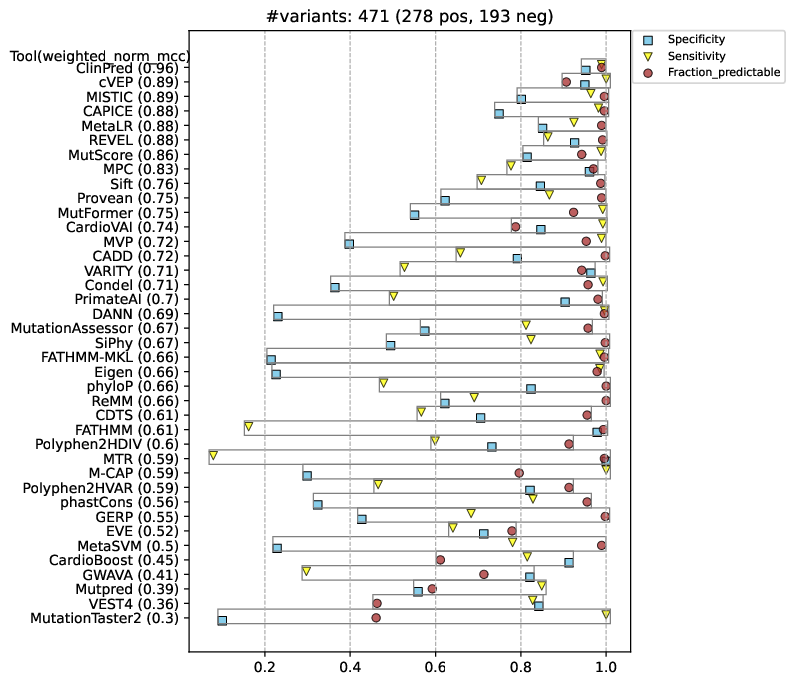

In [13]:
img_scatter = WImage(filename=scatter_fixed_thresh, resolution=100)
img_roc = WImage(filename=roc_variable_thresh, resolution=100)
img_scatter

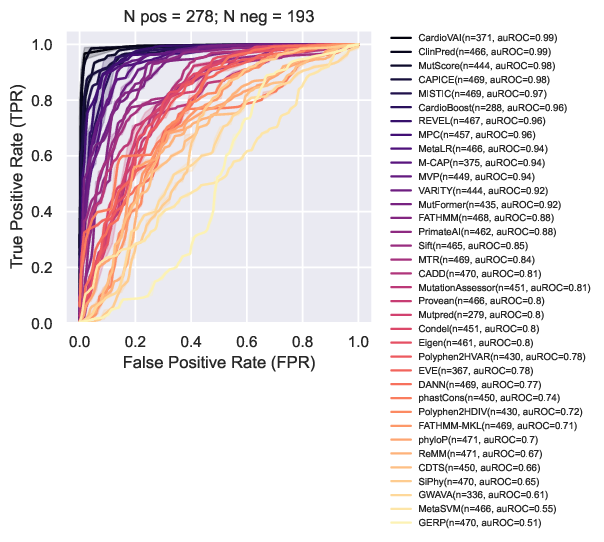

In [14]:
img_roc

### 2nd dataset - sHaRe cohort evaluation

This dataset was extracted from [this](https://www.ahajournals.org/doi/10.1161/CIRCULATIONAHA.117.033200) paper. We selected variants with Pathogenic/Likely pathogenic assignments. We just kept the variants that VEP did not throw an error due to allele mismatch, as well as those for which there are consequence blocks ocurring on a list of 62 genes belonging to a [pan cardiomyopathy panel](https://www.ncbi.nlm.nih.gov/gtr/tests/509149/). Additionally, all the variants present in the Clinvar HCM dataset were removed.

The majority of remaining variants refer to either missense or splice region variants. We just missense for evaluation:

`filter_vep -i share_pathogenic.vcf.gz --only_matched --filter 'Consequence match missense' | bgzip > sHaRe_pathogenic.vcf.gz`

Benign dataset was extracted from gnmoAD v2.1. We selected common variants with AF > 0.001 (> 0.1%) ocurring in one of the 62 genes present in the panel referred above (N=110762). We selected `missense_variants` (N=709) and additionally removed variants occurring in TTN (to avoid inflation of missense variants for a single gene, leading to a final N=356).\
We then made sure that this set does not overlap with any variant from the [Clinvar HCM dataset (described above)](#benchmark) and sHaRe cohort as well varians from the full Clinvar database with any of the following assginments: `Pathogenic`, `Likely_pathogenic`, `Pathogenic/Lilely_pathogenic`, `Uncertain_signficance` and `Conflicting_interpretations_of_pathogenicity`.\
The final benign set comprises 220 variants. To generate balanced datasets for benchmarking, we randomly selected two sets of (non-overlapping) 100 variants to be used as controls for this 2nd benchmark as well as for the 3rd (descbribed below). We call them `benign_set1` and `benign_set2`.

The final numbers for this second dataset:
- Pathogenic (N=94)
- Benign (gnomAD_set1) (N=100)

Since we are not analyzing anymore Clinvar VCFs (with specific `INFO` fields that VETA uses to extract variant class (`CLNSIG`, `CLNREVSTAT`)), we setup the input data for this analysis differently.\
In such cases, when the user provides a custom labelled dataset, we put the files in a separate directory. The benign variants must have one of the benign tags (`*benign*.vcf.gz` or `*neutral*.vcf.gz`) in the filename. On the other hand, the file with pathogenic variants must have one of the corresponding tags (`*pathogenic*.vcf.gz`, `*deleterious*.vcf.gz`). Only tools with the same VCF field in both files are going to be analyzed.

Finally, we run VETA with the following setup:

In [15]:
! veta benchmark --scopes_to_evaluate Conservation Whole_genome Protein \
                --types_of_variant all_types \
                --out_dir out_share2 \
                --metric weighted_norm_mcc \
                data/1_share_cohort/ &> log_share.txt

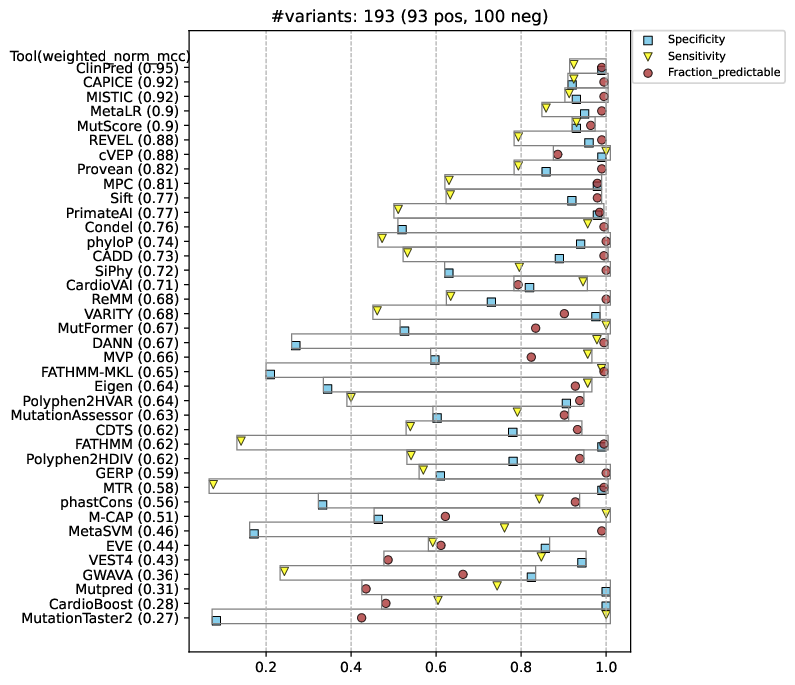

In [8]:
scatter_missense="out_share/tools_benchmark/all_types/performance_at_fixed_thresh/scatter_all_types_missense.pdf"
roc_missense="out_share/tools_benchmark/all_types/roc_analysis/ROC_missense.pdf"
heatmap_missense="out_share/tools_benchmark/all_types/performance_at_fixed_thresh/heatmap_missense.pdf"
img_scatter = WImage(filename=scatter_missense, resolution=100)
img_roc = WImage(filename=roc_missense, resolution=100)
img_heatmap = WImage(filename=heatmap_missense, resolution=100)
img_scatter

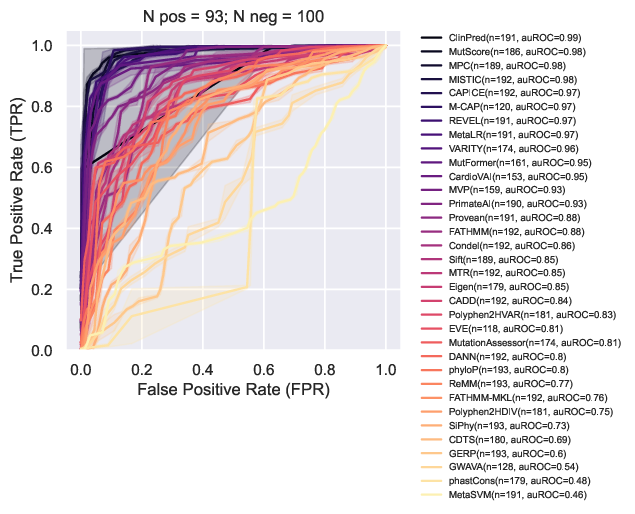

In [9]:
img_roc

### 3rd dataset - Evaluation on variants detected from comparing large case vs control (ExAC) cohorts

This dataset was extracted from [this](https://www.nature.com/articles/gim201690) paper.
This paper aggregates data from multiple HCM cohorts and statistically compares the excess of very rare variants in cases vs controls, being the controls the ExAC population. MAF threshold was set to <1x10-4.
For each of the 20 HCM-associated genes, the Odds Ratio and Etiological Fraction with 95% confidence intervals were calculated.
For our analysis we selected the subset of genes with signficant excess of rare variation in cases vs controls, and then, only those variants with Pathogenic/likely pathogenic interpretation (or with no conflicting classifications if variant occurs in more than one HCM cohort and was evaluated by different labs)

We then filtered those variants that occur in any of the previous datasets, and filtered for `missense` consequences.

The final dataset size comprises a total of 103 variants, many of them absent from the whole clinvar. There are some that are actually in Clinvar and were not selected in the first dataset:
- variants with `Uncertain_significance`
- variants with `Conflicting_interpretations_of_pathogenicity`
- variants with less than `1 star`
- variants that did not have any of the DB ids used to filter for HCM variants

As a benign set of variants for this experiments, we used the set2 of gnomAD variants generated and described before.

In [10]:
! veta benchmark --scopes_to_evaluate Conservation Whole_genome Protein \
                --types_of_variant all_types \
                --out_dir out_walsh \
                --metric weighted_norm_mcc \
                data/1_walsh_2017/ &> log_walsh.txt

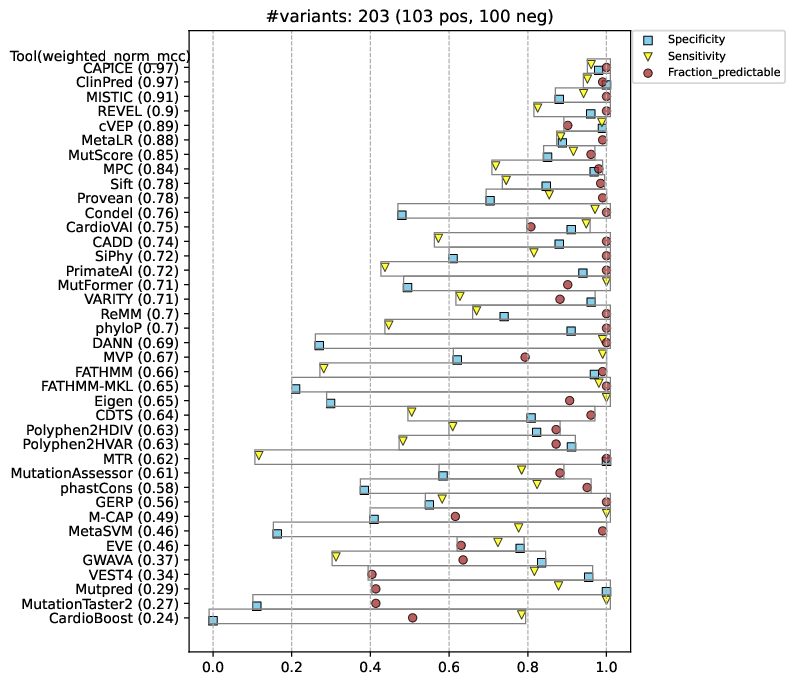

In [11]:
scatter_missense="out_walsh/tools_benchmark/all_types/performance_at_fixed_thresh/scatter_all_types_missense.pdf"
roc_missense="out_walsh/tools_benchmark/all_types/roc_analysis/ROC_missense.pdf"
img_scatter = WImage(filename=scatter_missense, resolution=100)
img_roc = WImage(filename=roc_missense, resolution=100)
img_scatter

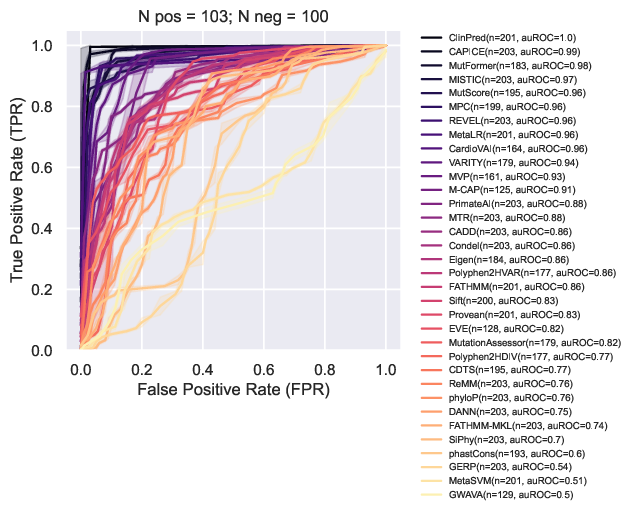

In [12]:
img_roc

### ***Summarizing the results***
These previous plots demonstrate a very good auROC score in comparison to the benchmarks using fixed thresholds.\
Hence, we created an auxiliar script to process VETA output from the different comparisons and quantify how much performance is affected by using the recommended reference threshold.

In [13]:
! python scripts/1_compare_auROC_vs_mcc.py \
    out_clinvar/1s_l/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv \
    out_share/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv \
    out_walsh/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv \
    --dataset_names Clinvar_HCM sHaRe Walsh_2017

/Users/pbarbosa/miniconda3/envs/veta/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/Users/pbarbosa/miniconda3/envs/veta/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1215: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
/Users/pbarbosa/miniconda3/envs/veta/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/Users/pbarbosa/miniconda3/envs/veta/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1215: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']


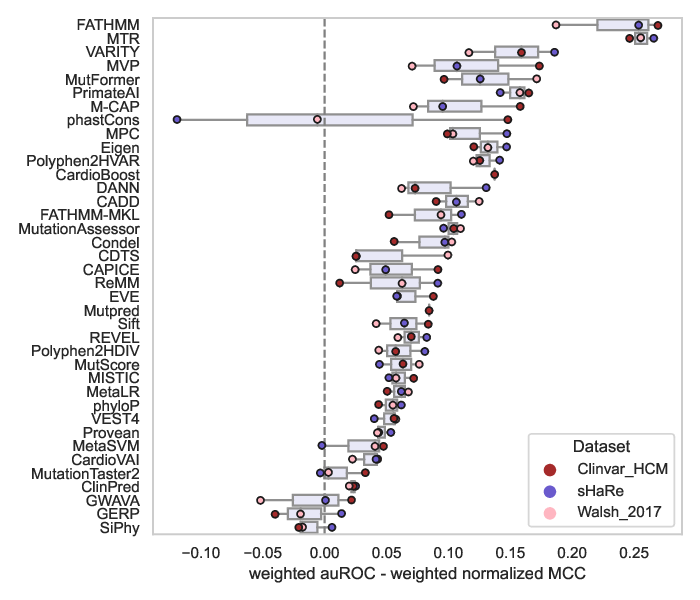

In [14]:
auROC_improvement_plot="plots/auROC_improvement.pdf"
img_auROC_improv = WImage(filename=auROC_improvement_plot, resolution=100)
img_auROC_improv

# 2nd analysis - Generate new reference thresholds for missense priorization in HCM

To adjust thresholds for clinical practice, we first merged all datasets into one. Then, we run VETA with the `--do_threshold_analysis` flag.

In [1]:
! veta benchmark --scopes_to_evaluate Conservation Protein Whole_genome \
                --types_of_variant all_types \
                --out_dir out_threshold_analysis \
                --do_threshold_analysis \
                --metric weighted_norm_mcc \
                data/2_merged/ &> log_threshold_analysis.txt

VETA will fine-tune optimal thresholds for different ratios of True positives / False positives using the `F beta formula`, as well as generate new config files with adjusted thresholds. As an example of the output of this analysis, we will show the results for one of the tools that had the greatest difference between the weighted auROC and weighted accuracy, MVP.

Recommended threshold was too relaxed for this data. At different levels of beta, we see quite different best thresholds (vertical dashed lines in blue scale). Giving more weight on precision than recall, we see a best threshold around 0.9, the value that maximizes the Fbeta function at a beta value of 0.5 On the other hand, if we want to give more weight to the recall (identify more pathogenic variants at the cost of introducing false positives), at a beta value of 1.5, the best threshold lies around 0.8, which still is more conservative than the reference threshold, 0.7. Hence, with this threshold analysis we adjusted the best threshold so that specificifity is improved (green line) while not loosing too much sensitivity (purple line).

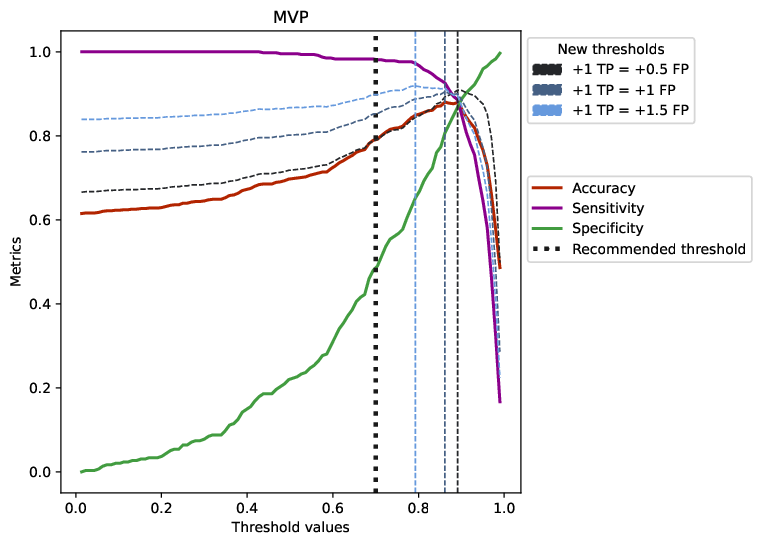

In [13]:
primateAI="out_threshold_analysis/thresholds_analysis/plots/threshold_MVP_missense.pdf"
img_primateAI = WImage(filename=primateAI, resolution=100)
img_primateAI

VETA allows to run the threshold analysis with an additional argument `--bootstrap`. When this argument is set, VETA will employ a bootstrapping procedure for each tool, where at each iteration an adjusted threshold is derived for the given bootstrap sample (the sample statistic here is the adjusted threshold). To evaluate the stability of the results, we compute the 0.025 and 0.975 quantiles of the distribution of the bootstrap sample statistic and compare with the best threshold derived for the data sample (the real dataset). If the distribution of the bootstrap sample follows a normal/symmetrical distribution we could even use these quantiles to estimate confidence intervals, but this may not be possible for several tools (e.g. data sample is not representative for confident estimates; tool is barely better than random guessing; tool is not robust to the different types of errors we try to control). Hence, in the paper, we do report the threshold range at which 95% of the bootstrap sample statistic lies (as a way to display the reliability), but caution should be taken as to interpret those results as confidence intervals. Users can allways inspect the bootstrap plots automatically generated by VETA to take at the bootstrap results with more detail (such as the one presented below).

In [2]:
! veta benchmark --scopes_to_evaluate Conservation Protein Whole_genome \
                --types_of_variant all_types \
                --out_dir out_threshold_analysis_bootstrap \
                --do_threshold_analysis \
                --bootstrap \
                --metric weighted_norm_mcc \
                data/2_merged/ &> log_threshold_analysis_bootstrap.txt

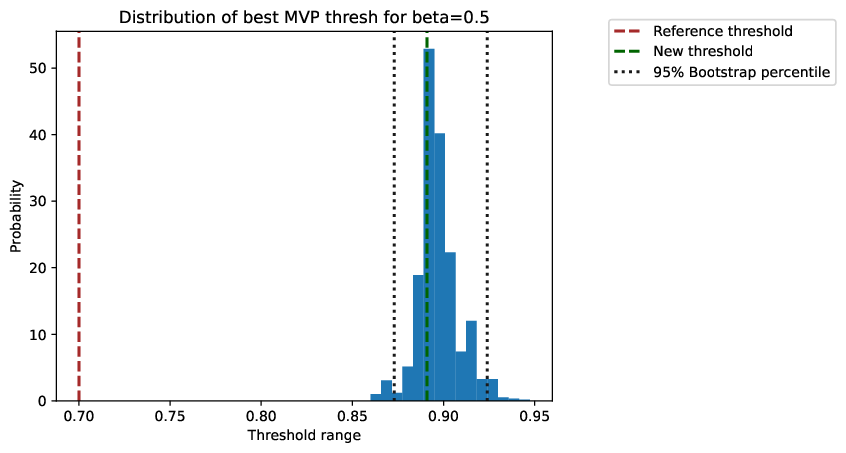

In [15]:
primateAI="out_threshold_analysis_bootstrap/thresholds_analysis/plots/bootstrapping/threshold_MVP_missense_f0.5.pdf"
img_primateAI = WImage(filename=primateAI, resolution=100)
img_primateAI

New thresholds are located at `out_threshold_analysis/out_threshold_analysis_bootstrap/new_thresholds/proposed_thresholds_missense.tsv`. Bear in mind that F1 performance at reference thresholds does not take into account missing data (the way we penalize default metrics in the whole paper). This is just added by VETA to compare with Fbeta performance at difference levels of beta.

In [7]:
import pandas as pd
thresholds = pd.read_csv("out_threshold_analysis_bootstrap/thresholds_analysis/new_thresholds/proposed_thresholds_missense.tsv", sep="\t")
thresholds

,Tool,Reference_threshold,F1_score_at_ref_thresh,Thresh_beta_0.5,Fbeta_0.5,Thresh_beta_1,Fbeta_1,Thresh_beta_1.5,Fbeta_1.5
0,GERP,4.400,0.62,"3.401 (2.602,3.601)",0.661,"2.583 (2.203,3.388)",0.733,"2.232 (0.057,2.679)",0.801
1,phyloP,7.367,0.60,"7.012 (4.39,7.122)",0.754,"3.558 (0.76,4.512)",0.735,"0.105 (0.022,1.068)",0.802
2,phastCons,0.990,0.71,"0.7 (0.532,1.0)",0.656,"0.54 (0.256,0.809)",0.739,"0.001 (0.001,0.692)",0.809
3,SiPhy,12.170,0.75,"11.823 (10.859,13.018)",0.721,"10.398 (9.507,11.931)",0.767,"7.264 (6.245,10.729)",0.818
4,CDTS,10.000,0.63,"26.756 (6.601,37.161)",0.699,"62.386 (37.155,85.472)",0.738,"86.139 (62.899,94.343)",0.811
5,Sift,0.001,0.77,"0.0 (0.001,0.038)",0.770,"0.05 (0.003,0.096)",0.793,"0.13 (0.043,0.196)",0.845
6,Polyphen2HVAR,0.978,0.58,"0.65 (0.359,0.861)",0.783,"0.24 (0.156,0.463)",0.810,"0.02 (0.012,0.265)",0.845
7,Polyphen2HDIV,0.978,0.66,"0.94 (0.511,0.957)",0.736,"0.5 (0.021,0.565)",0.766,"0.02 (0.0,0.064)",0.824
8,MutationTaster2,0.500,0.91,"0.99 (0.742,0.999)",0.880,"0.99 (0.228,0.992)",0.912,"0.23 (0.033,0.987)",0.940
9,MutationAssessor,1.935,0.76,"2.462 (2.429,2.828)",0.814,"1.106 (0.915,2.258)",0.777,"0.905 (0.085,1.122)",0.835


# 3rd analysis - Performance evaluation with optimized thresholds for HCM

We will now evaluate performance separately for each dataset with the optimized thresholds for different beta values:

- `Beta = 0.5 (precision is more important than recall)`
- `Beta = 1 (precision and recall are equally important)`
- `Beta = 1.5 (recall is more important than precision)`

On each case, the new `--config` file is given to provide custom config files with the adjusted thresholds generated before.

**Clinvar HCM**

In [5]:
from wand.image import Image as WImage

In [20]:
import subprocess
for beta in [0.5, 1, 1.5]:
    print(beta)
    log_file = open('log_clinvar_new_thresh_f{}.txt'.format(beta), 'w')
    subprocess.call(['veta', 'benchmark', 
                    '--config', 'out_threshold_analysis_bootstrap/thresholds_analysis/new_configs/new_config_missense_f{}.txt'.format(beta),
                    '--scopes_to_evaluate', 'Conservation', 'Whole_genome', 'Protein',
                    '--types_of_variant', 'all_types',
                    '--clinvar_stars', '1s_l',
                    '--out_dir', 'out_clinvar_new_thresh_f{}'.format(beta),
                    '--metric', 'weighted_norm_mcc',
                    'data/1_clinvar_hcm_1s_l/clinvar_HCM_filtered_missense.vcf.gz'], stdout=log_file)


0.5
1
1.5


**sHaRe**

In [21]:
for beta in [0.5, 1, 1.5]:
    print(beta)
    log_file = open('log_share_new_thresh_f{}.txt'.format(beta), 'w')
    subprocess.call(['veta', 'benchmark', 
                    '--config', 'out_threshold_analysis_bootstrap/thresholds_analysis/new_configs/new_config_missense_f{}.txt'.format(beta),
                    '--scopes_to_evaluate', 'Conservation', 'Whole_genome', 'Protein',
                    '--types_of_variant', 'all_types',
                    '--out_dir', 'out_share_new_thresh_f{}'.format(beta),
                    '--metric', 'weighted_norm_mcc',
                    'data/1_share_cohort'], stdout=log_file)

0.5
1
1.5


**Walsh_2017**

In [22]:
for beta in [0.5, 1, 1.5]:
    print(beta)
    log_file = open('log_walsh_new_thresh_f{}.txt'.format(beta), 'w')
    subprocess.call(['veta', 'benchmark', 
                    '--config', 'out_threshold_analysis_bootstrap/thresholds_analysis/new_configs/new_config_missense_f{}.txt'.format(beta),
                    '--scopes_to_evaluate', 'Conservation', 'Whole_genome', 'Protein',
                    '--types_of_variant', 'all_types',
                    '--out_dir', 'out_walsh_new_thresh_f{}'.format(beta),
                    '--metric', 'weighted_norm_mcc',
                    'data/1_walsh_2017'], stdout=log_file)

0.5
1
1.5


### ***Summarizing the results***

An auxiliar script was created to compare reference and adjusted thresholds

In [24]:
! python scripts/2_compare_ref_and_adjusted_threshold.py --metric weighted_norm_mcc \
    --ref_threshold out_clinvar/1s_l/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv out_share/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv out_walsh/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv \
    --beta_0.5 out_clinvar_new_thresh_f0.5/1s_l/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv out_share_new_thresh_f0.5/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv out_walsh_new_thresh_f0.5/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv \
    --beta_1 out_clinvar_new_thresh_f1/1s_l/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv out_share_new_thresh_f1/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv out_walsh_new_thresh_f1/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv \
    --beta_1.5 out_clinvar_new_thresh_f1.5/1s_l/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv out_share_new_thresh_f1.5/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv out_walsh_new_thresh_f1.5/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv \
    --dataset_names Clinvar_HCM SHaRe Walsh_2017

Figure(2000x800)


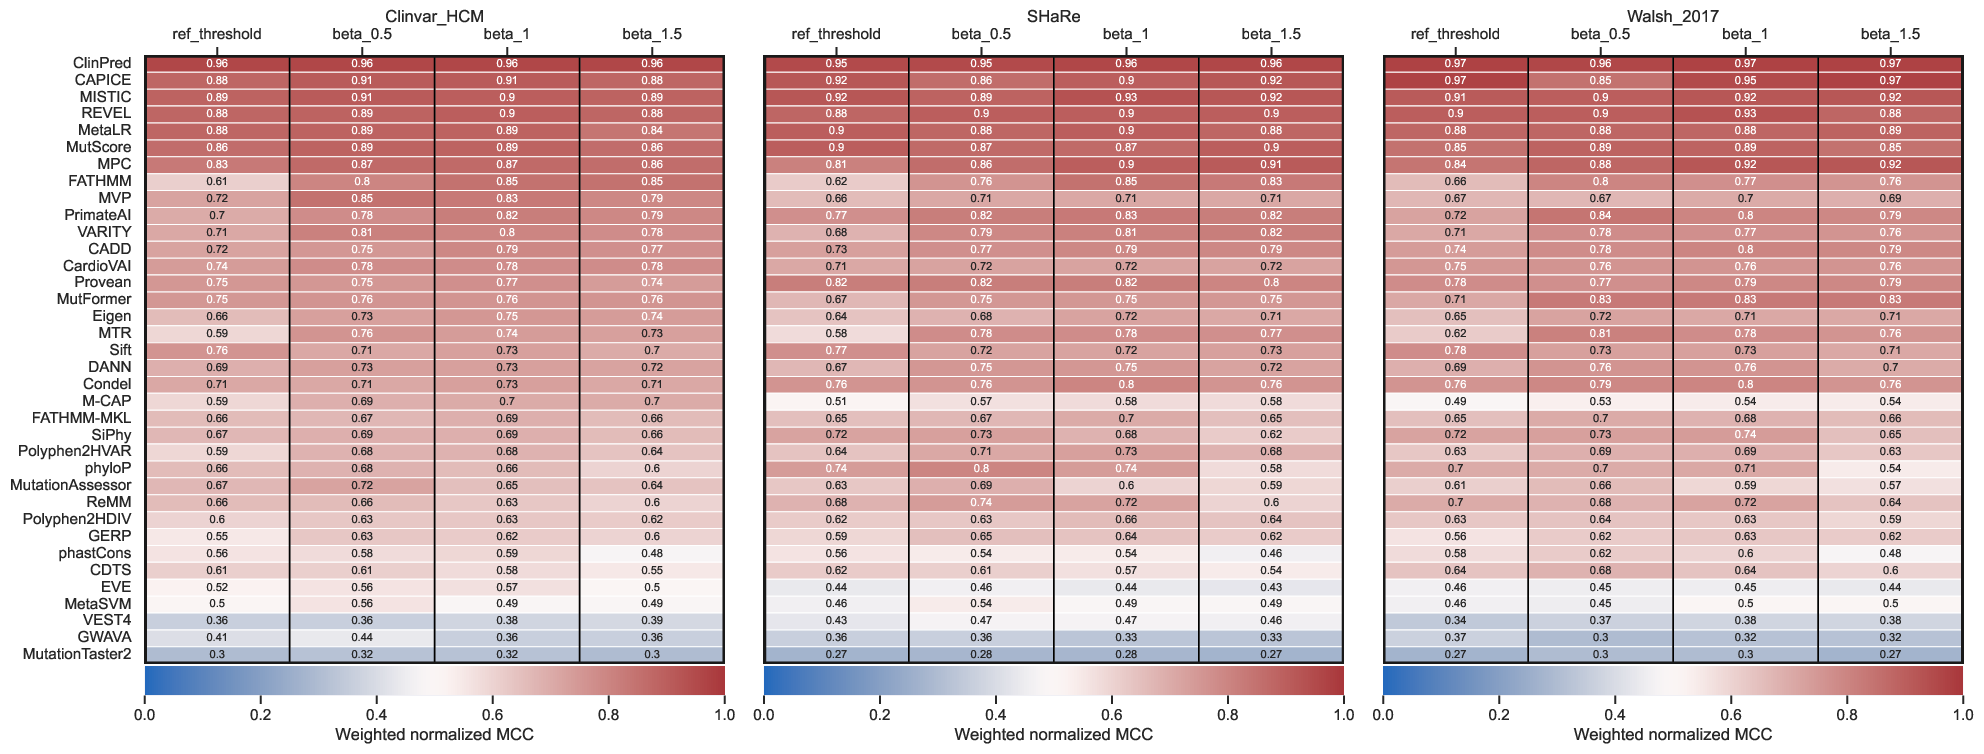

In [25]:
img_path="plots/ref_vs_adjusted.pdf"
img = WImage(filename=img_path, resolution=100)
img

# 4th analysis - Rank tools, deal with circularity issues on the top tools and then evaluate again 

 To rank tools across several datasets, we rank the tools for each dataset and simply take the mean rank for each of those. The top 8 tools were selected for downstream analysis

In [27]:
! python scripts/3_select_top_tools.py --metrics_file out_clinvar_new_thresh_f1/1s_l/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv \
                                                      out_share_new_thresh_f1/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv \
                                                      out_walsh_new_thresh_f1/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv \
                                    --dataset_names Clinvar_HCM SHaRe Walsh_2017 \
                                    --ranking_metrics weighted_norm_mcc    

Top 10 tools:
ClinPred
CAPICE
MISTIC
REVEL
MetaLR
MutScore
MPC
PrimateAI
FATHMM
CADD


### Excluding training data of top tools

For each of the top tools, we tried to obtain the variants used in the training (if applicable). This is only partially possible, because developers of tools that use any HGMD variants can't make them avaialable (e.g. FATHMM,REVEL). Additionally, it is common that training data isn't in standard formats, so we needed to process them. Lastly, some tools do not explicitly tell which variants were used in training (e.g. PrimateAI,MPC,ClinPred). Anyway, we gathered all the training datasets available, we processed some others according to the papers (e.g. ClinPred, MPC benign set) and generated VCFs to compared with our own sets. At the end, we were left with 119 (pathogenic) and 46 (benign) HCM variants that were not used in the training procedures of the top 10 tools (excluding PrimateAI that we could not access properly). 

We now evaluate the top tools on this dataset using the new thresholds with beta=1:

In [28]:
top = ['ClinPred', 'MISTIC', 'FATHMM', 'MPC', 'MetaLR', 'CAPICE', 'REVEL', 'CADD', 'PrimateAI', 'MutScore']
f = open('data/3_circularity/excluded_training_top_tools/top_tools.txt', 'w')
f.write('\n'.join(top) + "\n")

71

In [30]:
# Get new configs and subset those for top tools
! cp out_threshold_analysis_bootstrap/thresholds_analysis/new_configs/new_config_missense_f1.txt data/3_circularity
# ! fgrep -wf data/3_circularity/excluded_training_top_tools/top_tools.txt data/3_circularity/new_config_missense_f1.txt | grep -v MKL > data/3_circularity/config_subset_f1.txt 

**all tools**

In [31]:
! veta benchmark --scopes_to_evaluate Conservation Whole_genome Protein \
                --types_of_variant all_types \
                --out_dir out_circularity_training_data_excluded \
                --metric weighted_norm_mcc \
                --config data/3_circularity/new_config_missense_f1.txt \
                data/3_circularity/excluded_training_top_tools &> log_circularity_training_data_excluded.txt

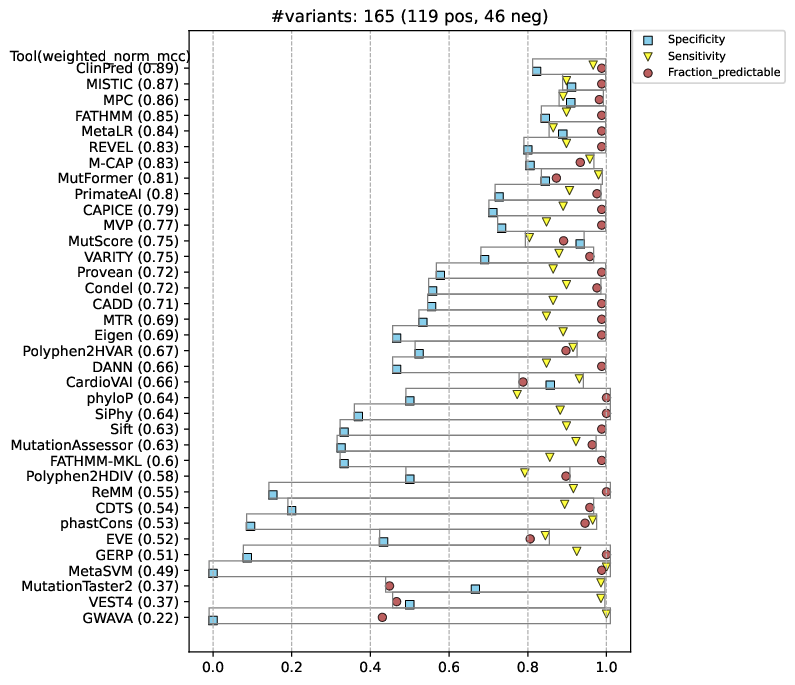

In [32]:
img_path="out_circularity_training_data_excluded/tools_benchmark/all_types/performance_at_fixed_thresh/scatter_all_types_missense.pdf"
img = WImage(filename=img_path, resolution=100)
img

### Using just recent HCM clinvar variants

We also extracted HCM-associated variants from Clinvar files that were released after one of the top tools was released. The most recent top tool is MutScore, which used Clinvar release 2020_11. Therefore, we evaluated all the 2022_04 variants that were absent from this release, with the same fitlering criteria as before (e.g. > 1 star)

**all tools**

We also run veta with all the tools in the same dataset to show that even though there may exist circularity issues with the non-top tools, they still score worse than the top ones.

In [33]:
! rm data/circularity/clinvar_recent/clinvar_HCM_missense_new_from_12_2020.vcf.gz.tsv
! veta benchmark --out_dir out_circularity_recent_clinvar \
                --types_of_variant all_types \
                --scopes_to_evaluate Conservation Whole_genome Protein \
                --clinvar_stars 1s_l \
                --metric weighted_norm_mcc \
                --config data/3_circularity/new_config_missense_f1.txt \
                data/3_circularity/clinvar_recent/clinvar_HCM_missense_new_from_12_2020.vcf.gz > log_circularity_recent_clinvar.txt

rm: data/circularity/clinvar_recent/clinvar_HCM_missense_new_from_12_2020.vcf.gz.tsv: No such file or directory


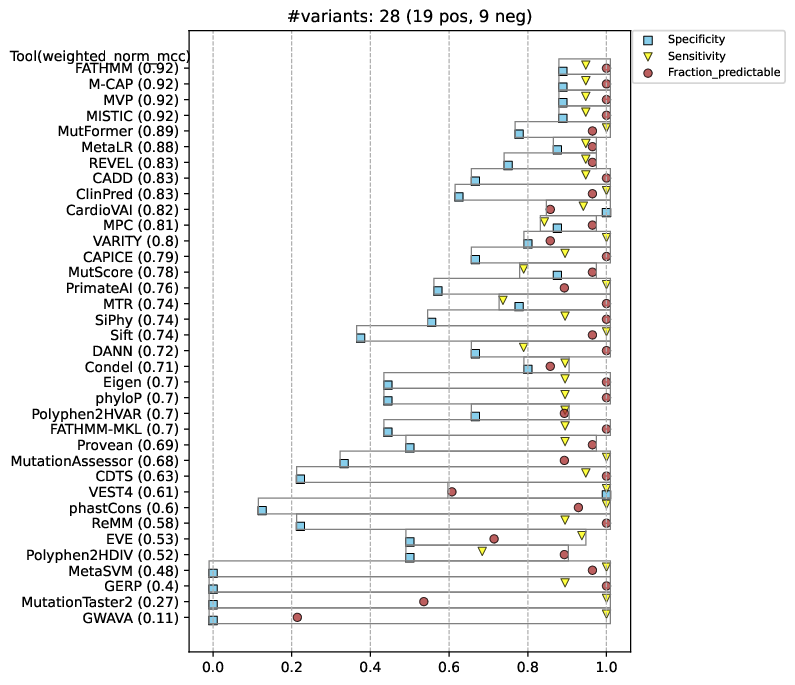

In [34]:
img_path="out_circularity_recent_clinvar/1s_l/tools_benchmark/all_types/performance_at_fixed_thresh/scatter_all_types_missense.pdf"
img = WImage(filename=img_path, resolution=100)
img

### 5th select best-performing tools after addressing circularity

In [35]:
! python scripts/4_select_top_tools_after_circularity.py \
    --metrics_file out_circularity_training_data_excluded/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv \
                   out_circularity_recent_clinvar/1s_l/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv \
    --dataset_names excluded_top_tools recent_clinvar \
    --ranking_metric weighted_norm_mcc    

Top tools
ClinPred
MISTIC
FATHMM
MPC
MetaLR
M-CAP
REVEL
MutFormer
PrimateAI
MVP


### 6th analysis VUS aggregated from sHaRe and walsh_2017 cohorts

In [46]:
top = ['ClinPred', 'MISTIC', 'FATHMM', 'MPC', 'MetaLR', 'M-CAP', 'REVEL', 'MutFormer', 'PrimateAI', 'MVP']
f = open('data/4_VUS/top_tools.txt', 'w')
f.write('\n'.join(top) + "\n")

70

In [47]:
! cp out_threshold_analysis_bootstrap/thresholds_analysis/new_configs/new_config_missense_f1.txt data/4_VUS
! fgrep -wf data/4_VUS/top_tools.txt data/4_VUS/new_config_missense_f1.txt | grep -v MKL > data/4_VUS/config_subset_f1.txt 

From those VUS that are present in Clinvar, we kept those that are classified as `Uncertain_significance` in the database.

In [3]:
! veta interrogate --scopes_to_evaluate Conservation Whole_genome Protein \
                --types_of_variant all_types \
                --out_dir out_VUS \
                --config data/4_VUS/config_subset_f1.txt  \
                data/4_VUS/HCM_VUS.vcf.gz &> log_VUS.txt

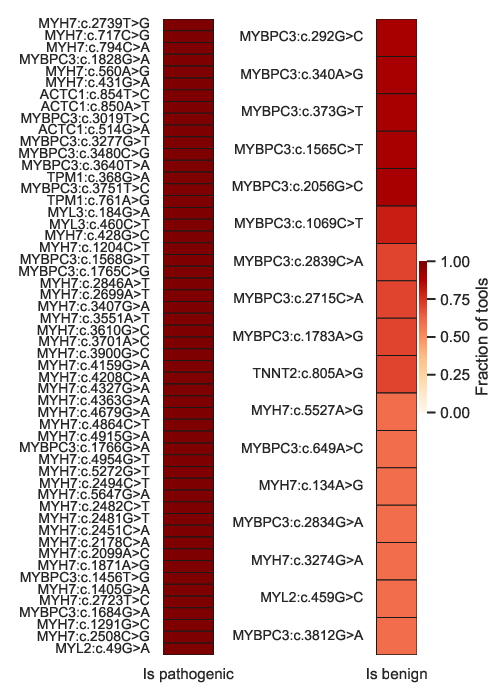

In [6]:
img_path="out_VUS/all_types/predictability_trade_off_top_patho_and_benign.pdf"
img = WImage(filename=img_path, resolution=100)
img

#### Generate 

### Comparison of HCM performance vs whole Clinvar database

In [50]:
! veta benchmark data/5_whole_clinvar/clinvar_full_missense_circularity.vcf.gz \
    --scopes_to_evaluate Conservation Whole_genome Protein \
    --types_of_variant all_types \
    --out_dir out_whole_clinvar \
    --metric weighted_norm_mcc \
    --clinvar_stars 0s_l \
    --skip_heatmap &> log_whole_clinvar.txt

In [51]:
! python scripts/5_compare_HCM_vs_whole_clinvar.py \
    --metrics_hcm out_circularity_recent_clinvar/1s_l/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv \
                  out_circularity_training_data_excluded/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv \
    --metrics_whole_clinvar out_whole_clinvar/0s_l/tools_benchmark/all_types/results_tsv/statistics_all_types_missense.tsv  

WilcoxonResult(statistic=447.5, pvalue=0.03601815370598225)
